##  Double descent in two layer neural network
This notebook contains the relevant code for the following figures in the paper "*Early stopping in deep networks: Double descent and how to eliminate it*":

- Figure 3

In [17]:
#!/usr/bin/env python
# coding: utf-8

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import argparse
import os
import datetime
import pathlib
import random
import json
import numpy as np
import math

import torch

import sys
sys.path.append('../code/')
from linear_utils import linear_model
from train_utils import save_config

In [18]:
# argument written in command line format
cli_args = '--seed 12 --save-results --jacobian --risk-loss L1 -t 50000 -w 1 0.01 --lr 0.000001 0.00008 -d 50 -n 100 --hidden 250 --sigmas geo --s-range 1 4'
#sigma_noise = 0.0

# "Multi-descent"
sigma_noise = 11.0

In [19]:
"""
A fully-connected ReLU network with one hidden layer, trained to predict y from x
by minimizing the MSE loss.
"""

# get CLI parameters
parser = argparse.ArgumentParser(description='CLI parameters for training')
parser.add_argument('--root', type=str, default='', metavar='DIR',
                    help='Root directory')
parser.add_argument('-t', '--iterations', type=int, default=1e4, metavar='ITERATIONS',
                    help='Iterations (default: 1e4)')
parser.add_argument('-n', '--samples', type=int, default=100, metavar='N',
                    help='Number of samples (default: 100)')
parser.add_argument('--print-freq', type=int, default=100,
                    help='CLI output printing frequency (default: 1000)')
parser.add_argument('--gpu', type=int, default=None,
                    help='Number of GPUS to use')
parser.add_argument('--seed', type=int, default=None,
                    help='Random seed')                        
parser.add_argument('-d', '--dim', type=int, default=50, metavar='DIMENSION',
                    help='Feature dimension (default: 50)')
parser.add_argument('--hidden', type=int, default=200, metavar='DIMENSION',
                    help='Hidden layer dimension (default: 200)')
parser.add_argument('--sigmas', type=str, default=None,
                    help='Sigmas')     
parser.add_argument('-r','--s-range', nargs='*', type=float,
                    help='Range for sigmas')
parser.add_argument('-w','--scales', nargs='*', type=float,
                    help='scale of the weights')
parser.add_argument('--lr', type=float, default=1e-4, nargs='*', metavar='LR',
                    help='learning rate (default: 1e-4)')              
parser.add_argument('--normalized', action='store_true', default=False,
                    help='normalize sample norm across features')
parser.add_argument('--risk-loss', type=str, default='MSE', metavar='LOSS',
                    help='Loss for validation')
parser.add_argument('--jacobian', action='store_true', default=False,
                    help='compute the SVD of the jacobian of the network')
parser.add_argument('--save-results', action='store_true', default=False,
                    help='Save the results for plots')
parser.add_argument('--details', type=str, metavar='N',
                    default='no_detail_given',
                    help='details about the experimental setup')


args = parser.parse_args(cli_args.split())

# directories
root = pathlib.Path(args.root) if args.root else pathlib.Path.cwd().parent

current_date = str(datetime.datetime.today().strftime('%Y-%m-%d-%H-%M-%S'))
args.outpath = (pathlib.Path.cwd().parent / 'results' / 'two_layer_nn' /  current_date)

if args.save_results:
    args.outpath.mkdir(exist_ok=True, parents=True)

if args.seed is not None:
    random.seed(args.seed)
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    
device = torch.device('cpu')
# device = torch.device('cuda') # Uncomment this to run on GPU

In [20]:
d_out = 1      # dimension of y

# sample training set from the linear model
lin_model = linear_model(args.dim, sigma_noise=sigma_noise, normalized=False, sigmas=args.sigmas, s_range=args.s_range)
Xs, ys = lin_model.sample(args.samples)
Xs = torch.Tensor(Xs).to(device)
ys = torch.Tensor(ys.reshape((-1,1))).to(device)

# sample the set for empirical risk calculation
Xt, yt = lin_model.sample(args.samples)
Xt = torch.Tensor(Xt).to(device)
yt = torch.Tensor(yt.reshape((-1,1))).to(device)

In [21]:
# define loss functions
loss_fn = torch.nn.MSELoss(reduction='sum')
risk_fn = torch.nn.L1Loss(reduction='mean') if args.risk_loss == 'L1' else loss_fn

In [22]:
def get_jacobian_two_layer(X, y, model, crit):
    
    grads = []
    for cx, cy in zip(X, y):

        cur_grads = []
        model.zero_grad()
        co = model(cx)
        co.backward(torch.ones(len(cy)))

        for p in model.parameters():
            if p.grad is not None and len(p.data.shape)>1:
                cur_grads.append(p.grad.data.numpy().flatten())
        grads.append(np.concatenate(cur_grads))
    return np.array(grads)

### Scaled stepsize

In [23]:
# Two layer neural network in pytorch
model = torch.nn.Sequential(
          torch.nn.Linear(args.dim, args.hidden),
          torch.nn.ReLU(),
          torch.nn.Linear(args.hidden, d_out),
        ).to(device)


#### re-initialize the weights (regular initialization is too unstable)
# if args.scales:
#     i = 0
#     with torch.no_grad():
#         for m in model:
#             if type(m) == torch.nn.Linear:
#                 if i == 0:
#                     m.weight.data.normal_(0, args.scales[0])
#                 if i == 1:
#                     m.weight.data.uniform_(-args.scales[1], args.scales[1])
#                 i += 1
                
                
# use kaiming initialization instead                
if args.scales:
    i = 0
    with torch.no_grad():
        for m in model:
            if type(m) == torch.nn.Linear:
                if i == 0:
                    torch.nn.init.kaiming_normal_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[0])
                if i == 1:
                    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[1])
                i += 1
                

# use same learning rate for the two layers in case of a single learning rate or none.
if isinstance(args.lr, float):
    args.lr = [args.lr] * 2

In [24]:
# compute the Jacobian at initialization
if args.jacobian:
    J = get_jacobian_two_layer(Xs, ys, model, loss_fn)
    uv, sv, vtv = np.linalg.svd(J)

    v1 = []
    v2 = []
    for i in range(sv.shape[0]):
        v1.append(np.linalg.norm(vtv[i,:][:np.prod([250, 50])]))
        v2.append(np.linalg.norm(vtv[i,:][-np.prod([1, 250]):]))
    v1 = np.array(v1)
    v2 = np.array(v2)
    vTrec = np.linalg.norm(np.stack((v1, v2)), axis=0)


    if args.save_results:
        save_config(args)

        np_save_file = args.outpath / ('two_layer_nn_jacobian_' + 
                                       str(args.scales[0]).replace('.', '-') + '_' + 
                                       str(args.scales[1]).replace('.', '-') + 
                                       '.txt')

        np.savetxt(np_save_file, 
                   np.column_stack((sv, 
                                    v1,
                                    v2,
                                    vTrec
                                   )), 
                   header='t vw vv vT', 
                   comments='',
                   newline='\n' )

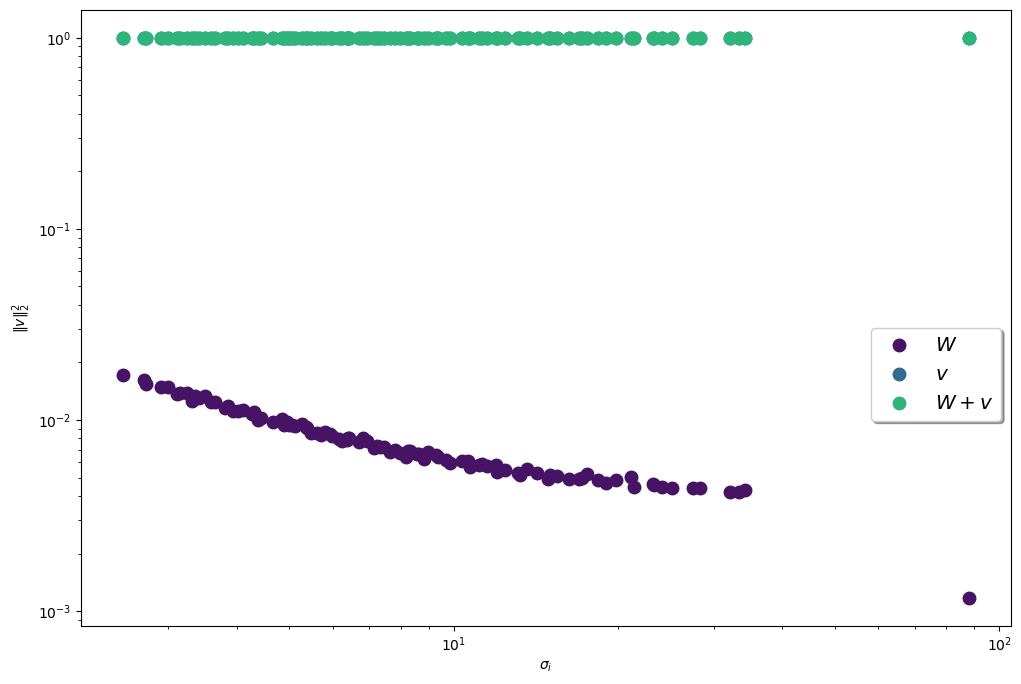

In [25]:
weights = [{'w': 0.01, 'v': 1}, {'w': 1, 'v': 1}, {'w': 1, 'v': 0.01}]
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000), cmap(650/1000)]
labelList = [r'$W$', r'$v$', r'$W + v$']

fig = plt.figure(figsize=(12,8))

ax_list = [plt.subplot(111)]

ax_list[0].scatter(sv, v1, 
                color=colorList[0], 
                label=labelList[0],
                lw=4)
ax_list[0].scatter(sv, v2, 
                color=colorList[1], 
                label=labelList[1],
#                 ls='dashed',
                lw=4)
ax_list[0].scatter(sv, vTrec, 
                color=colorList[2], 
                label=labelList[2],
#                 ls='dashed',
                lw=4)
    
ax_list[-1].legend(loc=0, bbox_to_anchor=(1, 0.5), fontsize='x-large',
                   frameon=True, fancybox=True, shadow=True, ncol=1)
ax_list[0].set_ylabel(r'$\Vert v \Vert_2^2$')

# for i, ax in enumerate(ax_list): ax.set_title(r'$w = $' + str(weights[i]['w']) + 
#                                               r';$v = $' + str(weights[i]['v']))
for ax in ax_list: ax.set_xlabel(r'$\sigma_i$')
for ax in ax_list: ax.set_xscale('log')
for ax in ax_list: ax.set_yscale('log')
plt.show()

In [26]:
# train the network
losses = []
risks = []
for t in range(int(args.iterations)):
    y_pred = model(Xs)

    loss = loss_fn(y_pred, ys)
    losses.append(loss.item())

    if not t % args.print_freq:
        print(t, loss.item())
        
    model.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        for param in model.parameters():
            param.data -= args.lr[i] * param.grad
            if not len(param.shape) > 1:
                i += 1
            
    with torch.no_grad():
        yt_pred = model(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks.append(risk.item())

        if not t % args.print_freq:
            print(t, risk.item())

0 51478.03125
0 18.960710525512695
100 518.0319213867188
100 13.712396621704102
200 40.181461334228516
200 13.803947448730469
300 3.951941728591919
300 13.810037612915039
400 0.4356673061847687
400 13.807246208190918
500 0.05194683372974396
500 13.805424690246582
600 0.006537395063787699
600 13.804588317871094
700 0.0008607626077719033
700 13.804261207580566
800 0.00011793660087278113
800 13.804139137268066
900 1.697730112937279e-05
900 13.804091453552246
1000 2.84940620076668e-06
1000 13.804076194763184
1100 6.674159749309183e-07
1100 13.804068565368652
1200 2.3689405281857034e-07
1200 13.804064750671387
1300 1.189670371104512e-07
1300 13.80406379699707
1400 7.27208231410259e-08
1400 13.80406379699707
1500 5.204776343248341e-08
1500 13.80406379699707
1600 3.867790354661338e-08
1600 13.804060935974121
1700 3.0251534610670205e-08
1700 13.804060935974121
1800 2.4830253408936187e-08
1800 13.804060935974121
1900 2.1835145247450782e-08
1900 13.804060935974121
2000 1.9470238754593083e-08
200

15900 7.592180772952872e-10
15900 13.80406379699707
16000 8.047496558027945e-10
16000 13.80406379699707
16100 7.443819449726163e-10
16100 13.80406379699707
16200 7.243020072600359e-10
16200 13.80406379699707
16300 7.66309293798173e-10
16300 13.80406379699707
16400 7.02395974716552e-10
16400 13.804062843322754
16500 7.865455509126207e-10
16500 13.804062843322754
16600 7.646395183691368e-10
16600 13.80406379699707
16700 7.178573846466918e-10
16700 13.804062843322754
16800 7.077960995083288e-10
16800 13.804062843322754
16900 7.226890752498605e-10
16900 13.804062843322754
17000 7.416179337305095e-10
17000 13.804062843322754
17100 7.139493996000112e-10
17100 13.804062843322754
17200 6.987722067641755e-10
17200 13.804062843322754
17300 7.08094527457348e-10
17300 13.804062843322754
17400 6.584915390739354e-10
17400 13.804062843322754
17500 6.531482577010195e-10
17500 13.804062843322754
17600 6.261476337421357e-10
17600 13.804062843322754
17700 6.604810587340637e-10
17700 13.804062843322754
17

31600 4.087357674542602e-10
31600 13.80406379699707
31700 3.525176262009211e-10
31700 13.80406379699707
31800 3.4814068294863887e-10
31800 13.80406379699707
31900 3.4804831239299006e-10
31900 13.80406379699707
32000 3.595875264217341e-10
32000 13.80406379699707
32100 3.5447161872426136e-10
32100 13.80406379699707
32200 3.689098471149066e-10
32200 13.80406379699707
32300 3.4873043341931975e-10
32300 13.80406379699707
32400 3.581806518049291e-10
32400 13.80406379699707
32500 3.662382064284486e-10
32500 13.80406379699707
32600 3.5852171231809393e-10
32600 13.80406379699707
32700 3.879666032879925e-10
32700 13.80406379699707
32800 3.808611759303915e-10
32800 13.80406379699707
32900 3.560206018882184e-10
32900 13.80406379699707
33000 3.81600140375582e-10
33000 13.80406379699707
33100 3.5209840598682263e-10
33100 13.80406379699707
33200 3.2759889245781437e-10
33200 13.804062843322754
33300 4.037974954407275e-10
33300 13.80406379699707
33400 3.617333654837296e-10
33400 13.80406379699707
33500

47300 3.875189613644636e-10
47300 13.80406379699707
47400 3.490501776504118e-10
47400 13.80406379699707
47500 3.2533226113073965e-10
47500 13.80406379699707
47600 3.4573904850176973e-10
47600 13.80406379699707
47700 3.1465990923962295e-10
47700 13.80406379699707
47800 2.6222896076788516e-10
47800 13.80406379699707
47900 2.8771612869959995e-10
47900 13.80406379699707
48000 3.4150421379663953e-10
48000 13.80406379699707
48100 2.9345020857718396e-10
48100 13.80406379699707
48200 3.2312247322252574e-10
48200 13.80406379699707
48300 3.12059322826741e-10
48300 13.80406379699707
48400 2.839786739095018e-10
48400 13.80406379699707
48500 3.385128288790895e-10
48500 13.80406379699707
48600 2.6584562329290407e-10
48600 13.80406379699707
48700 2.950844568694322e-10
48700 13.80406379699707
48800 3.106595536372936e-10
48800 13.80406379699707
48900 2.6279739495649324e-10
48900 13.80406379699707
49000 2.9696028969183885e-10
49000 13.80406379699707
49100 3.043499341437439e-10
49100 13.80406379699707
49

### Same stepsize

Train the network with the same stepsizes for both layers

In [27]:
model2 = torch.nn.Sequential(
           torch.nn.Linear(args.dim, args.hidden),
           torch.nn.ReLU(),
           torch.nn.Linear(args.hidden, d_out),
         ).to(device)      
                
# use kaiming initialization                
if args.scales:
    i = 0
    with torch.no_grad():
        for m in model2:
            if type(m) == torch.nn.Linear:
                if i == 0:
                    torch.nn.init.kaiming_normal_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[0])
                if i == 1:
                    torch.nn.init.kaiming_uniform_(m.weight, a=math.sqrt(5))
                    m.weight.data = torch.mul(m.weight.data, args.scales[1])
                i += 1
                

# use same learning rate for the two layers
if isinstance(args.lr, list):
    stepsize = [max(args.lr)] * 2

In [ ]:
# train the network
losses_same = []
risks_same = []
for t in range(int(args.iterations)):
    y_pred = model2(Xs)

    loss = loss_fn(y_pred, ys)
    losses_same.append(loss.item())

    if not t % args.print_freq:
        print(t, loss.item())

    model2.zero_grad()
    loss.backward()
    with torch.no_grad():
        i = 0
        for param in model2.parameters():
            param.data -= stepsize[i] * param.grad
            if not len(param.shape) > 1:
                i += 1
            
    with torch.no_grad():
        yt_pred = model2(Xt)
        
        risk = risk_fn(yt_pred, yt)
        risks_same.append(risk.item())

        if not t % args.print_freq:
            print(t, risk.item())

0 51491.875
0 19.076040267944336
100 0.0037376026157289743
100 12.65981674194336
200 9.676163870153687e-09
200 12.660387992858887
300 4.921046903305637e-11
300 12.660388946533203
400 8.089906522457113e-11
400 12.660388946533203
500 4.16112144741021e-11
500 12.660388946533203
600 5.560890636857607e-11
600 12.660390853881836
700 4.375180773230625e-12
700 12.660387992858887
800 3.31381588836166e-11
800 12.660388946533203
900 8.047641719688414e-11
900 12.660387992858887
1000 5.4434803886671546e-11
1000 12.660388946533203
1100 6.441604194495909e-11
1100 12.660388946533203
1200 5.689870796743435e-11
1200 12.660388946533203
1300 3.432459871888227e-11
1300 12.660387992858887
1400 6.279249342711068e-11
1400 12.660388946533203
1500 8.549619345821213e-12
1500 12.660388946533203
1600 3.3926694786856615e-11
1600 12.660387992858887
1700 6.3860028376439004e-12
1700 12.660388946533203
1800 4.339695269806043e-12
1800 12.660388946533203
1900 2.0268370315434936e-12
1900 12.660388946533203
2000 3.44880929

15900 1.978955888048972e-11
15900 12.660388946533203
16000 7.002301516401133e-12
16000 12.660388946533203
16100 1.2453607589613114e-11
16100 12.660387992858887
16200 8.449296817758523e-12
16200 12.660387992858887
16300 8.720940636308683e-13
16300 12.660388946533203
16400 2.1164639485427017e-11
16400 12.660387992858887
16500 6.268102703543832e-11
16500 12.660388946533203
16600 1.5975901157538885e-11
16600 12.660387992858887
16700 3.028401140969805e-11
16700 12.660387992858887
16800 1.2783787917136635e-11
16800 12.660387992858887
16900 2.6209256986930995e-11
16900 12.660387992858887
17000 1.7256918116714814e-11
17000 12.660388946533203
17100 3.846480078895098e-11
17100 12.660388946533203
17200 1.708416741408314e-11
17200 12.660387992858887
17300 1.3292478229232074e-11
17300 12.660388946533203
17400 6.981082378842984e-13
17400 12.660388946533203
17500 8.129552586666478e-12
17500 12.660387992858887
17600 3.5369485118508237e-12
17600 12.660388946533203
17700 1.0032114028390993e-12
17700 12.

31300 3.806732706834737e-12
31300 12.660387992858887
31400 5.6561422212553225e-12
31400 12.660387992858887
31500 6.218192627471808e-12
31500 12.660388946533203
31600 5.83134929232898e-12
31600 12.660388946533203
31700 4.0088488084677465e-12
31700 12.660388946533203
31800 4.623468274900233e-12
31800 12.660388946533203
31900 5.347958187407187e-12
31900 12.660388946533203
32000 1.467853616432535e-13
32000 12.660388946533203
32100 6.061574853166718e-11
32100 12.660388946533203
32200 9.995462790790555e-12
32200 12.660388946533203
32300 3.4943159477052177e-12
32300 12.660388946533203
32400 2.7621377407527348e-12
32400 12.660388946533203
32500 1.228586676838006e-12
32500 12.660388946533203
32600 1.213473765915296e-12
32600 12.660388946533203
32700 7.494060927371038e-12
32700 12.660388946533203
32800 2.3634427748220332e-12
32800 12.660388946533203
32900 2.3492319201068312e-12
32900 12.660388946533203
33000 8.233635995225086e-12
33000 12.660388946533203
33100 5.333747332691985e-12
33100 12.6603

In [ ]:
risks = np.array(risks)
risks_same = np.array(risks_same)
geo_samples = [int(i) for i in np.geomspace(1, len(risks)-1, num=700)]


if args.save_results:
    save_config(args)
    
    np_save_file = args.outpath / ('two_layer_nn_risk_same_stepsize_s' + 
                                   str(int(args.s_range[0])) + 
                                   str(int(args.s_range[1])) + 
                                   '.txt')

    geo_samples = [int(i) for i in np.geomspace(1, len(risks)-1, num=700)]

    np.savetxt(np_save_file, 
               np.column_stack((geo_samples, 
                                risks_same[geo_samples],
                                risks[geo_samples]
                               )), 
               header='t dd no-dd', 
               comments='',
               newline='\n' )

In [ ]:
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']

fig = plt.figure(figsize=(12,8))
ax = plt.subplot(111)
ax.set_xscale('log')


ax.plot(geo_samples, risks_same[geo_samples], 
        color=colorList[0], 
        label=labelList[0],
        lw=4)
ax.plot(geo_samples, risks[geo_samples], 
        color=colorList[1], 
        label=labelList[1],
        lw=4)

ax.legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
    frameon=False, fancybox=True, shadow=True, ncol=1)
ax.set_ylabel('risk')
ax.set_xlabel(r'$t$ iterations')

ax2 = fig.add_subplot(211)
ax2.set_xscale('log')
losses, losses_same = np.array(losses), np.array(losses_same)
ax2.plot(geo_samples, losses_same[geo_samples], 
        color=colorList[0], 
        label=labelList[0],
        lw=4)
ax2.plot(geo_samples, losses[geo_samples], 
        color=colorList[1], 
        label=labelList[1],
        lw=4)

ax2.set_ylabel('loss')
ax2.set_xlabel(r'$t$ iterations')

plt.show()

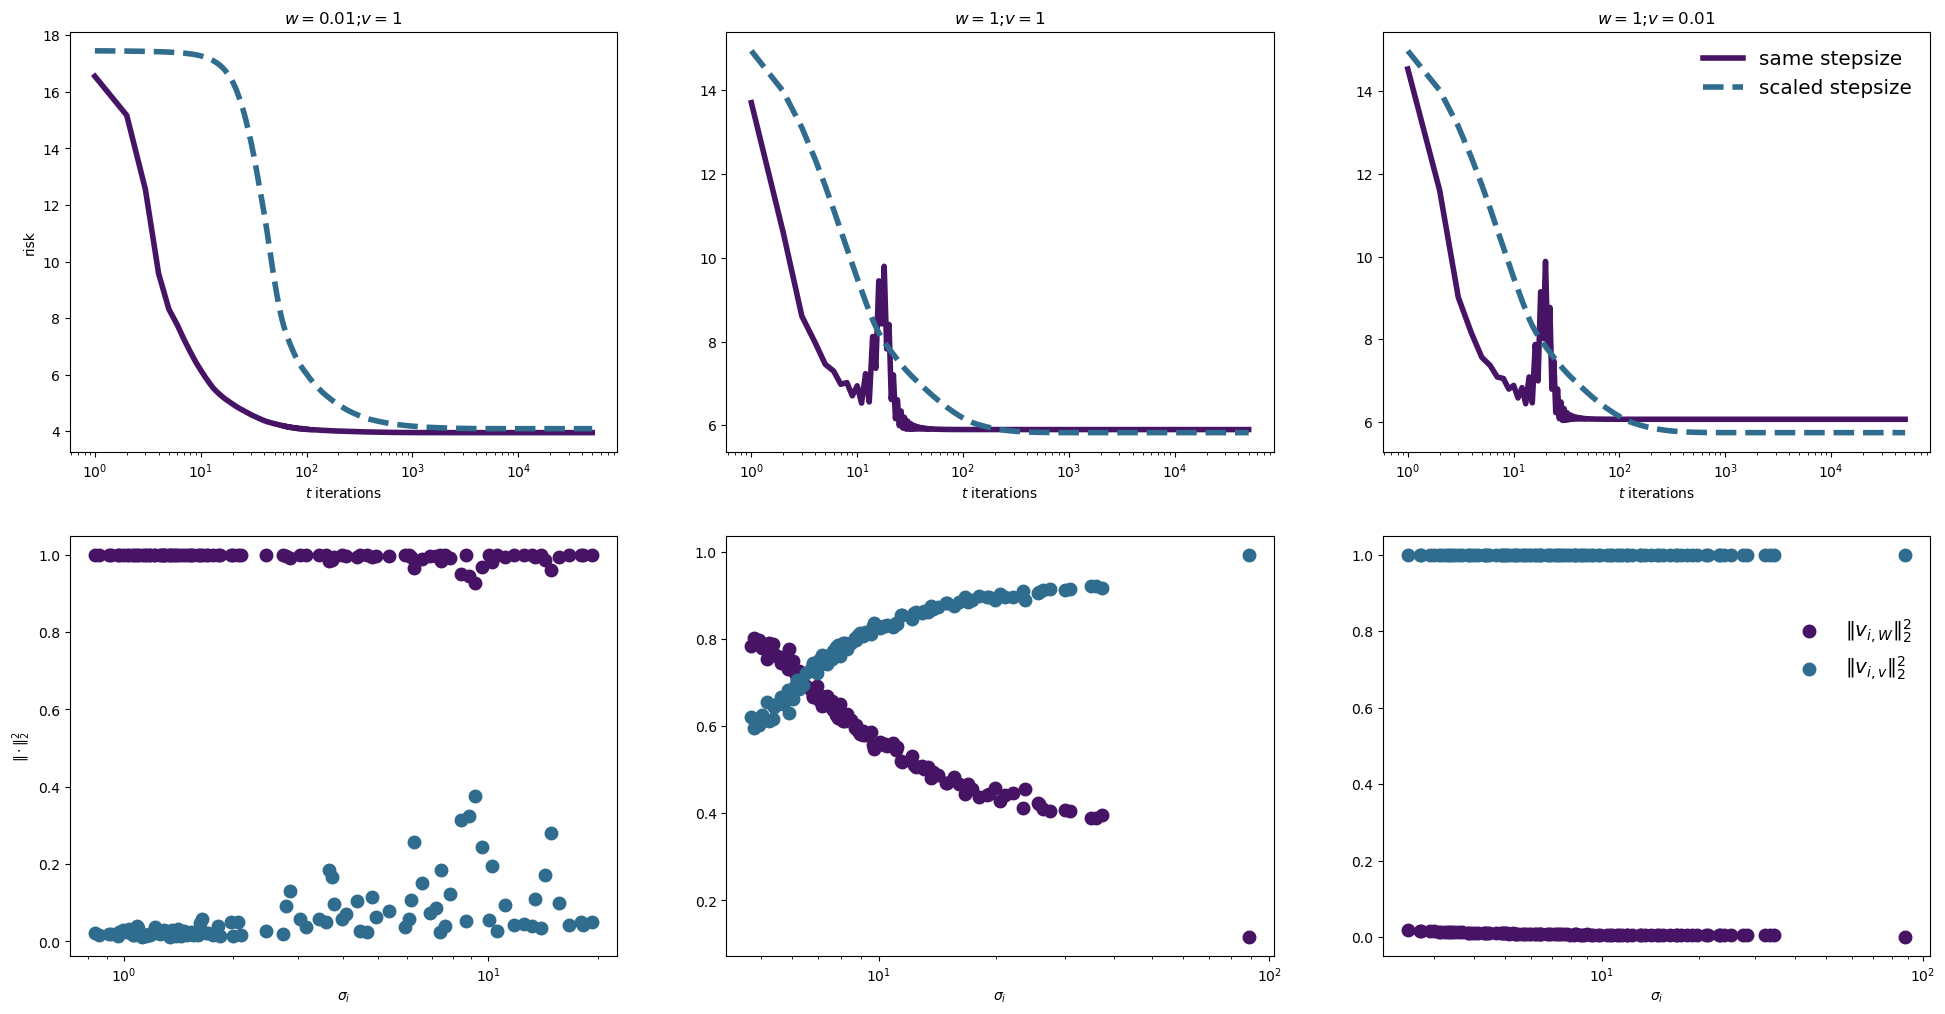

In [16]:
weights = [{'w': 0.01, 'v': 1}, {'w': 1, 'v': 1}, {'w': 1, 'v': 0.01}]
cmap = matplotlib.cm.get_cmap('viridis')
colorList = [cmap(50/1000), cmap(350/1000)]
labelList = ['same stepsize', 'scaled stepsize']
labelList2 = [r'$\Vert v_{i,W} \Vert_2^2$', r'$\Vert v_{i,v} \Vert_2^2$']

fig = plt.figure(figsize=(24,12))

ax_list = [plt.subplot(231), plt.subplot(232), plt.subplot(233)]
ax_list2 = [plt.subplot(234), plt.subplot(235), plt.subplot(236)]
for i, wlist in enumerate(weights):
    cur_w = wlist['w']
    cur_v = wlist['v']
    
    cur_risks = np.loadtxt('../results/two_layer_nn/' + 
                           'w' + ''.join(str(cur_w).split('.')) + 
                           '_v' + ''.join(str(cur_v).split('.')) +
                           '_lr80/risk.txt',
                          skiprows=1)
    
    cur_jac = np.loadtxt('../results/two_layer_nn/' + 
                         'w' + ''.join(str(cur_w).split('.')) + 
                         '_v' + ''.join(str(cur_v).split('.')) +
                         '_jacobian/' + 
                         'two_layer_nn_jacobian' + 
                         '_' + '-'.join(str(float(cur_w)).split('.')) + 
                         '_' + '-'.join(str(float(cur_v)).split('.')) + 
                         '.txt',
                          skiprows=1)
    
    ax_list[i].plot(cur_risks[:,0], cur_risks[:,1], 
                    color=colorList[0], 
                    label=labelList[0],
                    lw=4)
    ax_list[i].plot(cur_risks[:,0], cur_risks[:,2], 
                    color=colorList[1], 
                    label=labelList[1],
                    ls='dashed',
                    lw=4)
    
    ax_list2[i].scatter(cur_jac[:,0], cur_jac[:,1], 
                color=colorList[0], 
                label=labelList2[0],
                lw=4)
    ax_list2[i].scatter(cur_jac[:,0], cur_jac[:,2], 
                color=colorList[1], 
                label=labelList2[1],
                lw=4)
    
ax_list[-1].legend(loc=1, bbox_to_anchor=(1, 1), fontsize='x-large',
                   frameon=False, fancybox=True, shadow=True, ncol=1)
ax_list2[-1].legend(loc=1, bbox_to_anchor=(1, 0.85), fontsize='x-large',
                   frameon=False, fancybox=True, shadow=True, ncol=1)
ax_list[0].set_ylabel('risk')
ax_list2[0].set_ylabel(r'$\Vert \cdot \Vert_2^2$')

for i, ax in enumerate(ax_list): ax.set_title(r'$w = $' + str(weights[i]['w']) + 
                                              r';$v = $' + str(weights[i]['v']))
for ax in ax_list: ax.set_xlabel(r'$t$ iterations')
for ax in ax_list2: ax.set_xlabel(r'$\sigma_i$')
for ax in ax_list: ax.set_xscale('log')
for ax in ax_list2: ax.set_xscale('log')